Introduction

In [1]:
import pandas as pd
import numpy as np
import geopandas
%matplotlib inline

In [2]:
tree_data_url = "https://data.wprdc.org/dataset/9ce31f01-1dfa-4a14-9969-a5c5507a4b40/resource/d876927a-d3da-44d1-82e1-24310cdb7baf/download/trees_img.geojson"
#tree_file = open("trees_img.geojson")
neighborhoods = geopandas.read_file("./Neighborhoods/Neighborhoods_.shp")
df = geopandas.read_file(tree_data_url)
df.head()

,air_quality_benfits_so2avd_lbs,air_quality_benfits_total_dollar_value,co2_benefits_totalco2_lbs,stormwater_benefits_runoff_elim,air_quality_benfits_no2dep_dollar_value,air_quality_benfits_no2avd_lbs,id,condition,air_quality_benfits_vocavd_lbs,co2_benefits_sequestered_lbs,...,co2_benefits_decomp_lbs,air_quality_benfits_so2avd_dollar_value,air_quality_benfits_o3dep_lbs,property_value_benefits_leaf_surface_area,street,address_number,air_quality_benfits_pm10depdollar_value,height,stormwater_benefits_dollar_value,geometry
0,None,None,None,None,None,None,754166088,N/A,None,None,...,None,None,None,None,MONTICELLO ST,7428,None,0.0,None,POINT Z (-79.88972 40.45817 754166088.00000)
1,0.404518313668,11.4574381634,282.814600458,1743.33678249,0.992383683567,0.806602639112,1946899269,N/A,0.0312286783757,115.328075315,...,-96.345471327,1.40772373156,0.51434585922,36.5383334693,BALVER AVE,220,2.18532822434,0.0,13.9466942599,POINT Z (-80.06787 40.42927 1946899269.00000)
2,0.0869929269772,2.47465272109,94.2969674194,496.85727608,0.200391185065,0.190842327727,1431517397,Fair,0.00763782041405,45.2879502377,...,-6.86863949566,0.302735385882,0.101095075517,85.6403537258,SIDNEY ST,2822,0.444639118191,22.0,3.97485820864,POINT Z (-79.96503 40.42680 1431517397.00000)
3,0.138476374602,3.86561176462,118.357614601,596.957796467,0.312209046574,0.295642417598,994063598,Fair,0.0117260088601,33.5649564029,...,-5.77618257091,0.481897783617,0.161815871195,71.7718425022,SUISMON ST,608,0.687515577564,25.0,4.77566237175,POINT Z (-79.99928 40.45550 994063598.00000)
4,0.848114422269,25.6383946503,1808.88797305,5153.54970913,2.5388261995,1.58481358284,1591838573,Good,0.0598343427375,1391.74077362,...,-137.738656091,2.9514381895,1.27947519774,322.638488581,N NEGLEY AVE,1135,5.27533020212,52.0,41.2283976731,POINT Z (-79.92411 40.47667 1591838573.00000)


Checking if neighborhoods. 

In [3]:
neighborhoods['hood'].head()

0     Central Oakland
1       North Oakland
2        West Oakland
3    Crawford-Roberts
4      Strip District
Name: hood, dtype: object

In [4]:
def get_neighborhood(point):
    L = neighborhoods.loc[neighborhoods.contains(point)]
    return list(L['hood'])[0] if not L.empty else "" 

df["neighborhood"] = df.apply(lambda row: get_neighborhood(row['geometry']), axis = 1)
counts = df["neighborhood"].value_counts()
#pnt = df_sml.iloc[0]['geometry']
#get_neighborhood(pnt)['hood']


In [5]:
counts = counts.rename('tree_counts').to_frame().reset_index()
counts

,index,tree_counts
0,Squirrel Hill South,5073
1,Highland Park,2941
2,Squirrel Hill North,2083
3,South Side Flats,1693
4,Shadyside,1558
...,...,...
86,Arlington Heights,5
87,Esplen,3
88,South Shore,2
89,Glen Hazel,2


After loading and testing all the data, we can start looking at some graphs. This data is the distribution of tree counts over neighborhoods. From this data we can see that most neighborhoods have 0 - 1000 trees. However we can also see that there is an over achiever in the mix with 5000 trees. Let us investigate.

<AxesSubplot:ylabel='Frequency'>

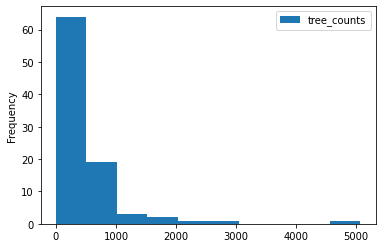

In [6]:
counts.plot.hist(bins = 10)

Let's get rid of the scrubs with <=500 trees. This leaves us with the cream of the crop.

<AxesSubplot:ylabel='index'>

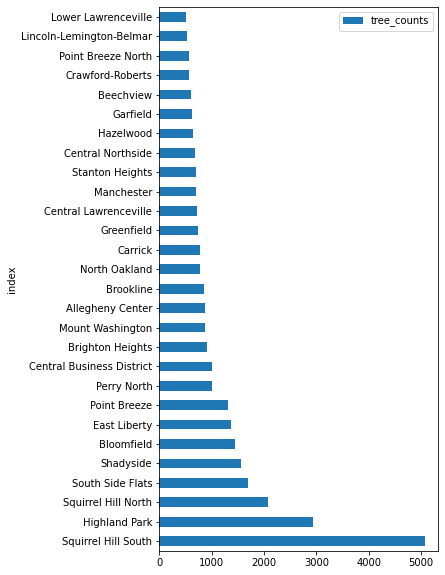

In [7]:
counts[counts['tree_counts'] > 500].set_index('index').plot.barh(figsize = (5, 10))

And we have found our overacheiver. I mean just look at that long bar. I'm sure many panthers are already getting ready to pounce on it.

In [8]:
tree_count_map = neighborhoods.merge(counts, how = 'left', left_on = 'hood', right_on = 'index')

Ok so let us look at our results on a map.

<AxesSubplot:>

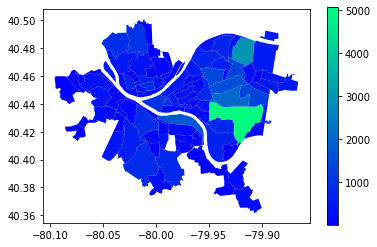

In [9]:
tree_count_map.plot(column = 'tree_counts', legend = True, cmap = 'winter')

We found the over acheiver. And it's so big and so cyan. Looks like the raw tree count has a bias for large areas. Let's try to compensate for that. We can try looking at the tree density in each neighborhood for more unbiased data.

The program is yelling that the distances and areas might not be accurate as there is no way to project a sphere to a rectangle without compromise. So if you don't choose the correct projection, there can be consequences. One of the best visual examples of this is that Russia looks larger than Africa on a map. I am ignoring these warnings as I am only interested in relative areas and distances. Also the curvature of Earth across Pittsburgh is negligible.

/tmp/ipykernel_23387/3313668857.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tree_count_map['area'] = tree_count_map.area


<AxesSubplot:>

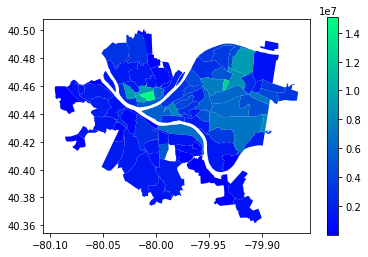

In [10]:
#tree_count_map.to_crs(3857)
tree_count_map['area'] = tree_count_map.area
#tree_count_map['area_norm'] = tree_count_map['area']/tree_count_map['area'].max()
tree_count_map['tree_count_norm'] = tree_count_map['tree_counts']/tree_count_map['area']
tree_count_map.plot(column = 'tree_count_norm', legend = True, cmap = 'winter')

In [11]:
tree_norm = tree_count_map.set_index('hood')['tree_count_norm'].sort_values()
tree_norm.tail(20)

hood
Knoxville                    5.210986e+06
North Shore                  5.474211e+06
North Oakland                5.651054e+06
Central Business District    5.693324e+06
East Allegheny               6.023813e+06
Shadyside                    6.152410e+06
Squirrel Hill North          6.197863e+06
South Side Flats             6.583269e+06
Squirrel Hill South          6.908355e+06
Point Breeze North           7.037679e+06
Bloomfield                   7.436772e+06
Crawford-Roberts             7.995375e+06
Regent Square                8.209773e+06
East Liberty                 8.546037e+06
Highland Park                9.193629e+06
Manchester                   9.205225e+06
Central Northside            9.464183e+06
Allegheny West               9.935745e+06
Friendship                   1.239533e+07
Allegheny Center             1.507301e+07
Name: tree_count_norm, dtype: float64

<AxesSubplot:ylabel='hood'>

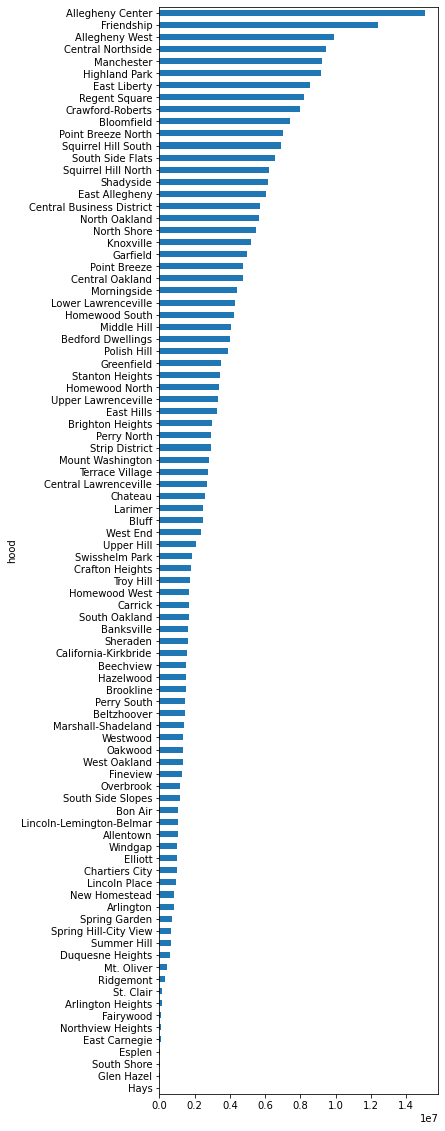

In [12]:
tree_norm.plot.barh(figsize = (5, 20))

In [13]:
cat_rescues = pd.read_csv('cat_rescues.csv')
cat_rescues

,Latitudes,Longitudes
0,40.601959,-79.750203
1,40.553207,-79.759972
2,40.542960,-79.775739
3,40.494213,-79.933062
4,40.464518,-79.941676
5,40.455457,-79.904086
6,40.436305,-79.883558
7,40.432078,-79.884451
8,40.442340,-80.000782
9,40.451310,-80.020360


In [14]:
rescue_locs = geopandas.points_from_xy(cat_rescues.Longitudes, cat_rescues.Latitudes)

In [15]:
neighborhoods['centroid'] = neighborhoods.centroid

/tmp/ipykernel_23387/2684470615.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  neighborhoods['centroid'] = neighborhoods.centroid


,hood,closest_shelter
5,Central Business District,0.002791
86,West End,0.003544
75,Homewood West,0.003982
69,Point Breeze North,0.004287
37,Garfield,0.005383
...,...,...
88,Glen Hazel,0.052866
79,New Homestead,0.058300
72,Overbrook,0.059025
71,Lincoln Place,0.067465


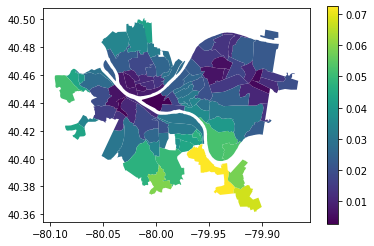

In [16]:
neighborhoods['closest_shelter'] = neighborhoods.apply(
    lambda x: rescue_locs.distance(x['centroid']).min(), axis = 1)
neighborhoods.plot(column = 'closest_shelter', legend = True)
neighborhoods.sort_values('closest_shelter')[['hood', 'closest_shelter']]

Combining metrics

In [17]:
fin_data = tree_count_map[['hood', 'tree_counts', 'tree_count_norm']]
shelter_data = neighborhoods[['hood', 'closest_shelter']]
fin_data = fin_data.merge(shelter_data, how = 'left', left_on = 'hood', right_on = 'hood')
fin_data = fin_data.set_index('hood')

Normalising data

In [18]:
fin_data['tree_counts'] /= fin_data['tree_counts'].max()
fin_data['tree_count_norm'] /= fin_data['tree_count_norm'].max()  
fin_data['closest_shelter'] /= fin_data['closest_shelter'].max()
fin_data['closest_shelter'] = 1 - fin_data['closest_shelter'] 

<AxesSubplot:ylabel='hood'>

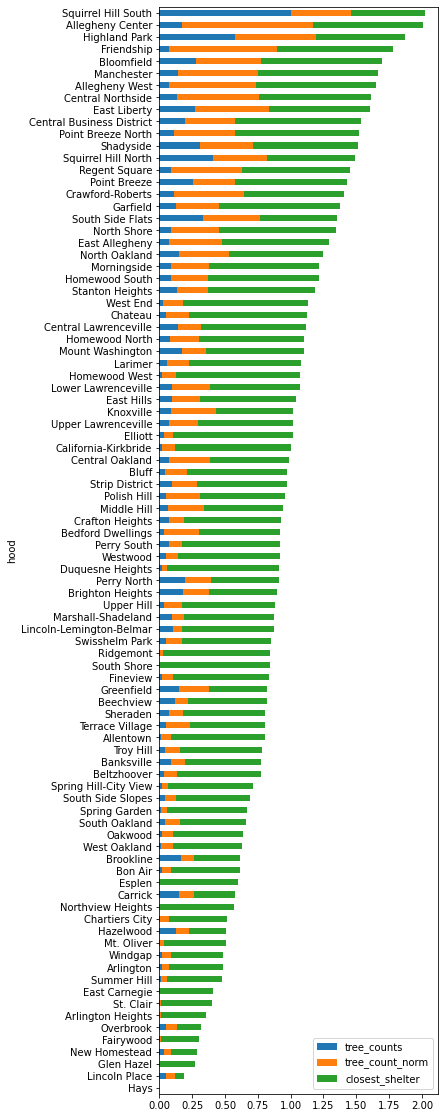

In [19]:
sorted_data = fin_data.sum(axis = 1).sort_values()
fin_data = fin_data.reindex(sorted_data.index)
fin_data.plot.barh(stacked = True, figsize = (5, 20))

In [20]:
fin_data['total'] = fin_data.sum(axis=1)
fin_data.tail(10)

,tree_counts,tree_count_norm,closest_shelter,total
hood,,,,
Central Business District,0.197516,0.377716,0.961479,1.536712
East Liberty,0.269269,0.566976,0.764500,1.600745
Central Northside,0.132860,0.627889,0.849056,1.609806
Allegheny West,0.076089,0.659174,0.917346,1.652610
Manchester,0.139365,0.610709,0.913123,1.663198
Bloomfield,0.283067,0.493383,0.915728,1.692178
Friendship,0.071358,0.822353,0.888141,1.781852
Highland Park,0.579736,0.609940,0.682907,1.872583
Allegheny Center,0.170905,1.000000,0.834580,2.005485
